# A short demo to show how B converges to the data-specific pseudoinverse of W

In [1]:
import torch
import torchvision
import numpy as np

Here we will show how gradient descent on the energy E = 1/2 ||r - B W r||^2 aligns B with the data-specific pseudoinverse of W. In this demo, we keep W fixed and assume only one data vector r.

In [31]:
# define the update rule for B
def update_B(r, W, B):
    grad_B = np.outer((- r + B @ W @ r), (W @ r).T)
    return grad_B

# define the data-specific pseudoinverse of W given the data vector r
def ds_pinv(r, W):
    gen_pseudo = np.outer(r,r.T) @ W.T / np.linalg.norm(W @ r)**2
    return gen_pseudo

# define the mismatch energy
def mismatch_energy(r, W, B):
    return .5 * np.linalg.norm(r - B @ W @ r)**2

# Calculate the cosine similarity between two tensors
# using the Frobenius inner product
def cosine_similarity_tensors(A, B):
    product = np.trace(A.T @ B)
    norm = (np.trace(A.T @ A))**.5 * (np.trace(B.T @ B))**.5

    # returns cos(theta)
    return product / norm

We are now ready to define our 'net', which here just means the matrices W and B. We do so for several examples: a small test net, and some larger nets.

# Test: small net with 3 -> 2

In [32]:
# define parameters of net
layers = [3, 2]
steps = 5000
bw_lr = 1e-3
alpha = 1e+1
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-10:
            print("reached precision of 10^-10")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.32671996941857245
mm energy after 100 steps: 0.28679153343618874
mm energy after 150 steps: 0.32811333680453747
mm energy after 200 steps: 0.3726407551825971
mm energy after 250 steps: 0.4049022819611777
mm energy after 300 steps: 0.42555787856590416
mm energy after 350 steps: 0.43808333129383265
plateau detected, reducing alpha to 1.0
mm energy after 400 steps: 0.39739670392375315
mm energy after 450 steps: 0.36253092624822375
mm energy after 500 steps: 0.3325693344775825
mm energy after 550 steps: 0.30675108338964513
mm energy after 600 steps: 0.28444323683764955
mm energy after 650 steps: 0.2651180208759397
mm energy after 700 steps: 0.2483342666841488
mm energy after 750 steps: 0.23372225567058266
mm energy after 800 steps: 0.22097132888242543
mm energy after 850 steps: 0.20981974395118297
mm energy after 900 steps: 0.20004636075439666
mm energy after 950 steps: 0.1914638162199951
mm energy after 1000 steps: 0.18391291282497482
mm energy after 1050 steps

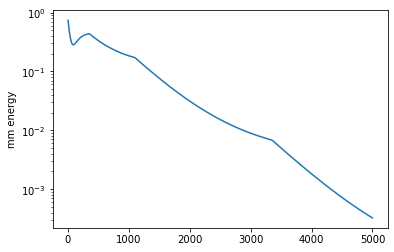

In [33]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

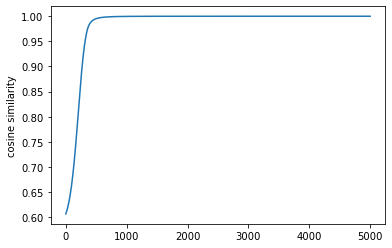

In [34]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

In [35]:
B_array[-1] @ W 

array([[0.47954859, 0.32548549, 0.18644496],
       [0.69871689, 0.47773238, 0.27048619],
       [0.05463746, 0.03486331, 0.02198704]])

# A larger net with 100 -> 10

In [36]:
# define parameters of net
layers = [100, 10]
steps = 5000
bw_lr = 1e-4
alpha = 1e+3
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-20:
            print("reached precision of 10^-20")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.4011665410683836
mm energy after 100 steps: 0.40116654106838384
plateau detected, reducing alpha to 100.0
mm energy after 150 steps: 0.005527636579651112
mm energy after 200 steps: 0.0055276365796510995
plateau detected, reducing alpha to 10.0
mm energy after 250 steps: 5.7249468237969604e-05
mm energy after 300 steps: 5.724946823796838e-05
plateau detected, reducing alpha to 1.0
mm energy after 350 steps: 5.745256854749688e-07
mm energy after 400 steps: 5.74525685474953e-07
plateau detected, reducing alpha to 0.1
mm energy after 450 steps: 5.747293800088669e-09
mm energy after 500 steps: 5.747293800080929e-09
plateau detected, reducing alpha to 0.010000000000000002
mm energy after 550 steps: 5.747497554238509e-11
mm energy after 600 steps: 5.747497554401717e-11
plateau detected, reducing alpha to 0.0010000000000000002
mm energy after 650 steps: 5.747517930631768e-13
mm energy after 700 steps: 5.747517929676091e-13
plateau detected, reducing alpha to 0.00010

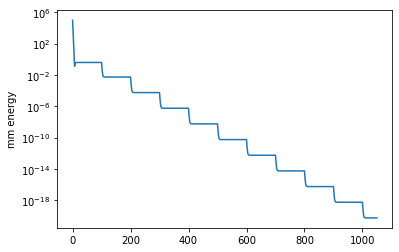

In [37]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

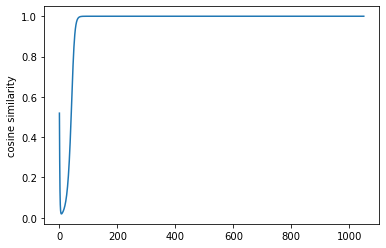

In [38]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

# The inverse: 10 -> 100

In [39]:
# define parameters of net
layers = [10, 100]
steps = 5000
bw_lr = 1e-3
alpha = 1e+2
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-20:
            print("reached precision of 10^-20")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 0.03903427464529699
mm energy after 100 steps: 0.03903427464529703
plateau detected, reducing alpha to 10.0
mm energy after 150 steps: 0.0005302547161950015
mm energy after 200 steps: 0.0005302547161949911
plateau detected, reducing alpha to 1.0
mm energy after 250 steps: 5.482537544678557e-06
mm energy after 300 steps: 5.482537544678328e-06
plateau detected, reducing alpha to 0.1
mm energy after 350 steps: 5.501038939304018e-08
mm energy after 400 steps: 5.501038939303865e-08
plateau detected, reducing alpha to 0.010000000000000002
mm energy after 450 steps: 5.502894227900749e-10
mm energy after 500 steps: 5.50289422795574e-10
plateau detected, reducing alpha to 0.0010000000000000002
mm energy after 550 steps: 5.503079808377827e-12
mm energy after 600 steps: 5.503079808549825e-12
plateau detected, reducing alpha to 0.00010000000000000003
mm energy after 650 steps: 5.503098367270532e-14
mm energy after 700 steps: 5.503098365087963e-14
plateau detected, reducin

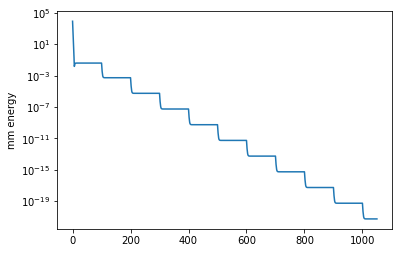

In [40]:
import matplotlib.pyplot as plt
plt.plot(mm_energy)
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

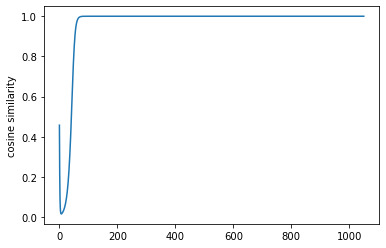

In [41]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()

# A realistic net with 784 -> 500

In [42]:
# define parameters of net
layers = [784, 500]
steps = 5000
bw_lr = 1e-7
alpha = 1e+6
alpha_decay = 1e-1

# after how many steps to eval model
per_steps = 50

# init weights
W = np.random.rand(layers[1],layers[0])
B = np.random.rand(layers[0],layers[1])
r = np.random.rand(layers[0])
B0 = B.copy()
B_array = []

# keep W fixed, but change B
mm_energy = []
for i in range(steps):
    B -= bw_lr * (update_B(r, W, B) + alpha * B)
    B_array.append(B.copy())
    
    mm_energy.append(mismatch_energy(r, W, B))
    
    # every 50 steps, take average and see if energy doesn't move
    if i % per_steps == 0 and i != 0:
        if np.isnan(mm_energy[-1]) or np.isinf(mm_energy[-1]):
            raise ValueError('mm energy inf or nan')
        print(f'mm energy after {i} steps: {mm_energy[-1]}')
        if mm_energy[-1] < 1e-20:
            print("reached precision of 10^-20")
            break
        if np.sqrt(np.cov(mm_energy[-per_steps:])) < 1e-2 * np.mean(mm_energy[-per_steps:]):
            alpha *= alpha_decay
            print(f'plateau detected, reducing alpha to {alpha}')

mm energy after 50 steps: 119846576093.72385
mm energy after 100 steps: 16227383369.61758
mm energy after 150 steps: 2197227474.0011926
mm energy after 200 steps: 297516796.412781
mm energy after 250 steps: 40287932.438295424
mm energy after 300 steps: 5456471.651763763
mm energy after 350 steps: 739347.0451204297
mm energy after 400 steps: 100305.93984933906
mm energy after 450 steps: 13654.477509217146
mm energy after 500 steps: 1875.8601656641918
mm energy after 550 steps: 264.1183790042887
mm energy after 600 steps: 39.665379994370966
mm energy after 650 steps: 6.98475608657099
mm energy after 700 steps: 1.7172993624490454
mm energy after 750 steps: 0.6940767287662629
mm energy after 800 steps: 0.44145950285945257
mm energy after 850 steps: 0.36528001000201005
mm energy after 900 steps: 0.3395198051603311
mm energy after 950 steps: 0.3303484204672237
mm energy after 1000 steps: 0.3270152848426821
mm energy after 1050 steps: 0.32579443517962775
plateau detected, reducing alpha to 10

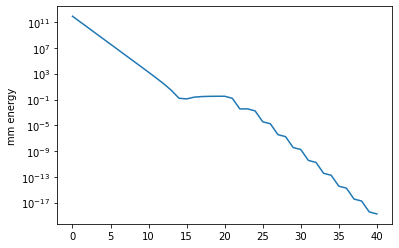

In [43]:
import matplotlib.pyplot as plt
plt.plot(mm_energy[1::50])
plt.yscale('log')
plt.ylabel('mm energy')
plt.show()

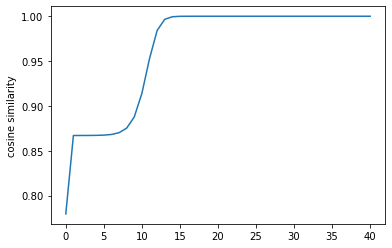

In [44]:
cos_sim = [cosine_similarity_tensors(B_mat, ds_pinv(r, W)) for B_mat in B_array[1::50]]
    
plt.plot(cos_sim)
plt.ylabel('cosine similarity')
plt.show()